# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

(I strongly recommend you to try this notebook on the Udacity workspace first before running it locally on your desktop/laptop, as performance might suffer in different environments)

In [1]:
# install package for displaying animation
!pip install JSAnimation

# install gym atari support(deprecated)
# !pip install gym[atari]
# !pip install gym[accept-rom-license]
# !pip install --force-reinstall ale-py==0.7

# install gym atari support
# https://blog.csdn.net/dannnnnnnnnnnn/article/details/122776301
# !pip uninstall atari-py -y
# !pip uninstall gym[atari] -y
!pip install gym==0.19.0
!pip install atari_py==0.2.6

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cpu


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



original img size: (210, 160, 3)


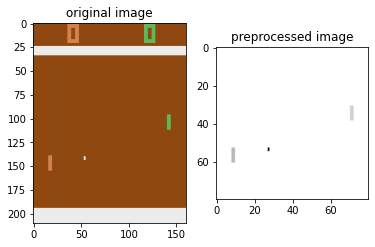

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

print('original img size:',frame.shape)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # output = 20x20 here
        # input=batch_size*num_features*height*width
        # https://blog.csdn.net/bigFatCat_Tom/article/details/91619977
        self.conv1 = nn.Conv2d(2, 32, kernel_size=8, stride=4)
        self.ba2d1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.ba2d2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, stride=1)
        self.ba2d3 = nn.BatchNorm2d(64)
        self.size=64*7*7
        
        # fully connected layers
        self.fc1 = nn.Linear(self.size, int(self.size*0.5))
        self.ba1d1 = nn.BatchNorm1d(int(self.size*0.5))
        self.fc2 = nn.Linear(int(self.size*0.5), int(self.size*0.25))
        self.ba1d2 = nn.BatchNorm1d(int(self.size*0.25))
        self.fc3 = nn.Linear(int(self.size*0.25), 1)
        self.sig = nn.Sigmoid()
        
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.ba2d1(self.conv1(x)))
        x = F.relu(self.ba2d2(self.conv2(x)))
        x = F.relu(self.ba2d3(self.conv3(x)))
        # flatten the tensor
        x = x.view(-1,self.size)
        # print('x shape:',x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.sig(self.fc3(x))
        return x

# use your own policy!
policy=Policy().to(device)


# policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [5]:
pong_utils.play(env, policy, time=100) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [6]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=15, seed=12345)
probs, states, actions, rewards = pong_utils.collect_trajectories(envs, policy, tmax=100)

In [7]:
# torch.view sample elements by order, permute/reshape does not
# https://blog.csdn.net/york1996/article/details/81949843
# the 1st dim of trajectory output is timestamp, 2nd dim is states of traj values at timestamp
import copy
import numpy as np

print('probs len:',len(probs), 'probs[0] shape',probs[0].shape)
print('states len:',len(states),'states[0] shape',states[0].shape)
print('actions len:',len(actions), 'actions[0] shape:',actions[0].shape)
print('rewards len:',len(rewards), 'rewards[0] shape:',rewards[0].shape)
print(rewards[0])
new_prob=pong_utils.states_to_prob(policy, states)
print('new_prob shape:',new_prob.shape)

# reward discount test
rewards1 = copy.deepcopy(rewards)

discount = 0.995
discounts = [discount**i for i in range(len(rewards))]
rewards[-1] *= discounts[-1]
for t in range(len(rewards)-2,-1,-1):
    rewards[t] *= discounts[t]
    rewards[t] += rewards[t+1]
print(rewards[0])
print(type(rewards[0]))
print(np.mean(rewards, axis=1).shape)

rewards = rewards1
discount = discount**np.arange(len(rewards))
rewards = np.asarray(rewards)*discount[:,np.newaxis]

# convert rewards to future rewards
rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
print(rewards_future[0])


probs len: 100 probs[0] shape (15,)
states len: 100 states[0] shape torch.Size([15, 2, 80, 80])
actions len: 100 actions[0] shape: (15,)
rewards len: 100 rewards[0] shape: (15,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
new_prob shape: torch.Size([100, 15])
[-3.71490906 -2.20509479 -3.71490906 -3.71490906 -2.20670579 -3.71490906
 -2.42047539 -3.71490906 -3.71490906 -3.71490906 -2.20509479 -3.71490906
 -2.88699572 -3.71490906 -3.09687024]
<class 'numpy.ndarray'>
(100,)
[-3.71490906 -2.20509479 -3.71490906 -3.71490906 -2.20670579 -3.71490906
 -2.42047539 -3.71490906 -3.71490906 -3.71490906 -2.20509479 -3.71490906
 -2.88699572 -3.71490906 -3.09687024]


# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

In [8]:
# Note:
# 1. There are two parts of loss, first part is the total reward loss, second part is the regularization loss
# to prevent prob close to 0 or 1(which is not required)
# 2. The theta_prime is actually the same as theta, but the former has grad while the latter doesn't
def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01, loss_type=1):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs).float().to(device)

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
    # discounted accumulated future rewards
    discounts = [discount**i for i in range(len(rewards))]
    rewards[-1] *= discounts[-1]
    for t in range(len(rewards)-2,-1,-1):
        rewards[t] *= discounts[t]
        rewards[t] += rewards[t+1]
    rewards = np.asarray(rewards)
    
    # rewards normalization
    mean = np.expand_dims(np.mean(rewards, axis=1), 1)
    std = np.expand_dims(np.std(rewards, axis=1) + 1e-10, 1)
    rewards = (rewards - mean) / std
    
    rewards = torch.from_numpy(rewards).float().to(device)
    
    # get expected rewards
    if loss_type == 1:
        ratios = torch.log(new_probs)
    else:
        ratios = new_probs / old_probs
    rewards *= ratios

    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(beta*entropy+rewards)

rewards1 = copy.deepcopy(rewards)
Lsur= surrogate(policy, probs, states, actions, rewards, loss_type=2)
Lsur1 = pong_utils.surrogate(policy, probs, states, actions, rewards1)

print(Lsur)
print(Lsur1)

tensor(1.00000e-03 *
       6.9283)
tensor(1.00000e-03 *
       6.9283)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [13]:
from parallelEnv import parallelEnv
import numpy as np
import matplotlib.pyplot as plt

# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500
# episode = 800

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=15, seed=1234)

discount_rate = .995
beta = .01
tmax = 320
loss_type = 2

# keep track of progress
mean_rewards = []

from pong_utils import GetFolderPath
save_name = 'reinforce'+'_type_'+str(loss_type)+'_tmax_'+str(tmax)+'_beta_'+str(beta)+'_disc_'+str(discount_rate)
save_path = GetFolderPath(save_name)

policy=Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
    
    # only for performance display
    total_rewards = np.sum(rewards, axis=0)

    # this is the SOLUTION!
    # use your own surrogate function
    L = -surrogate(policy, old_probs, states, actions, rewards, discount_rate, beta, loss_type)
    
    # L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    if len(mean_rewards) > 1 and mean_rewards[-1] > mean_rewards[-2]:
        model_name = 'epi_' +str(e)+ '_reward_' + str(mean_rewards[-1]) + '_inc_'
        torch.save(policy, save_path+model_name+'REINFORCE.policy')
    elif len(mean_rewards) > 1 and mean_rewards[-1] <= mean_rewards[-2]:
        model_name = 'epi_' +str(e)+ '_reward_' + str(mean_rewards[-1]) + '_dec_'
        torch.save(policy, save_path+model_name+'REINFORCE.policy')

        
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

# plot results
fig = plt.figure(figsize=[30, 15])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.xlabel("episode"), plt.ylabel("rewards")
ax.plot(mean_rewards)
ax.legend(['mean rewards'])
pic_name = 'epi_' + str(episode) + '_mean_rewards.png'
plt.savefig(save_path + pic_name)
plt.close(fig)
    

Episode: 20, score: -12.800000
[-13.  -9. -12. -12. -12. -13. -11. -15. -16. -16. -13. -13. -13. -12.
 -12.]


Episode: 40, score: -9.333333
[-11. -11.  -7. -11. -10. -11. -11. -11.  -5.  -8. -10.  -8. -10. -12.
  -4.]


Episode: 60, score: -5.466667
[-10. -10.  -4.  -6.  -8.  -5.  -5.  -4.  -7.  -2.  -6.  -4.  -4.  -1.
  -6.]


Episode: 80, score: -2.866667
[ -4.  -6.  -1.   1.  -1.  -1.  -1.  -1.  -7.  -1.  -1. -12.  -1.  -6.
  -1.]


Episode: 100, score: -1.466667
[-2. -3. -3. -1. -1. -1. -1.  1. -4. -4. -1. -1. -1.  1. -1.]


Episode: 120, score: -0.466667
[ 1. -6. -1.  1.  2.  0. -1.  0.  1. -1. -1.  0.  1. -1. -2.]


Episode: 140, score: 1.000000
[ 1.  1.  2.  2. -1.  1. -2.  1.  2.  2.  2.  0.  1.  1.  2.]


Episode: 160, score: 1.133333
[ 2. -1.  1.  2.  2.  2. -1. -1.  2.  2.  0.  2.  2.  2.  1.]


Episode: 180, score: 1.600000
[2. 2. 0. 2. 0. 2. 2. 2. 2. 2. 2. 2. 1. 1. 2.]


Episode: 200, score: 1.400000
[1. 2. 2. 2. 2. 2. 0. 2. 2. 1. 2. 1. 2. 0. 0.]


Episode: 220, score: 1.733333
[2. 1. 2. 2. 2. 0. 1. 2. 2. 2. 2. 2. 2. 2. 2.]


Episode: 240, score: 2.400000
[3. 2. 1. 2. 3. 3. 2. 1. 3. 3. 3. 3. 3. 3. 1.]


Episode: 260, score: 2.266667
[3. 2. 0. 3. 2. 2. 3. 3. 3. 2. 2. 2. 2. 2. 3.]


Episode: 280, score: 2.133333
[ 0.  3.  3.  3.  3.  3.  3.  3.  0.  3.  3.  3.  0. -1.  3.]


Episode: 300, score: 2.266667
[2. 2. 2. 3. 3. 2. 2. 2. 2. 2. 3. 3. 2. 2. 2.]


Episode: 320, score: 2.733333
[3. 3. 2. 3. 1. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3.]


Episode: 340, score: 2.933333
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2.]


Episode: 360, score: 2.400000
[ 3.  3.  3.  3.  1.  3.  0.  3.  3.  3.  3. -1.  3.  3.  3.]


Episode: 380, score: 0.533333
[-2.  2. -2.  2.  3.  2. -4.  2. -1. -2. -4.  3.  3.  3.  3.]


Episode: 400, score: 2.800000
[3. 3. 3. 3. 3. 3. 0. 3. 3. 3. 3. 3. 3. 3. 3.]


Episode: 420, score: 3.000000
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


Episode: 440, score: 3.000000
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


Episode: 460, score: -2.200000
[-5.  2.  2. -5. -5. -5.  2. -5. -5. -5. -5.  2.  2.  2. -5.]


Episode: 480, score: 3.000000
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


Episode: 500, score: 2.600000
[3. 3. 1. 3. 3. 3. 3. 3. 3. 3. 1. 3. 3. 3. 1.]


In [14]:
# play game after training!
pong_utils.play(env, policy, time=2000) 

In [ ]:
plt.plot(mean_rewards)

In [ ]:
# save your policy!
torch.save(policy, 'REINFORCE.policy')

# load your policy if needed
# policy = torch.load('REINFORCE.policy')

# try and test out the solution!
# policy = torch.load('PPO_solution.policy')